# Klasyfikacja za pomocą algorytmu wektorów wspierających (SVM)
## Materiały
Na tych ćwiczeniach zapoznamy się z zastosowaniem SVM do klasyfikacji.
Poniżej znajduje się fragment kodu dostarczający kilku funkcji,  z których dziś będziemy korzystać. 

In [1]:
import numpy as np
import matplotlib.pylab as plt

#### Definicje funkcji pomocniczych, których nie musisz modyfikować

In [2]:
def rysujDaneGrup(X, y, marker, xlabel, ylabel, legend_list):
    '''X - macierz wartości wejściowych zorganizowana tak, że kolejne przykłady są
    w wierszach, kolumny to kolejne wynmiary  wejścia,
    y - wektor określający przynależność do grupy, indeksy tego wektora odpowiadają wierszom macierzy X,
    marker - zestaw markerów do oznaczania elementów grup, markerów powinno być tyle, ile jest grup'''
    p=[]
    for i,g in enumerate(np.unique(y)):
        g = int(g)
        tmp =plt.plot(X[np.where(y==g),0], X[np.where(y==g),1],marker[i])
        p.append(tmp[0])
    plt.legend(p, legend_list)
    # Dodajemy napisy
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def rysujPodzial(model, X):
    # wytworzymy siatkę punktów pokrywających obszar danych:
    N = 100 # ilość punktów siatki w jednym wymiarze
    os_x = np.linspace(X.min(), X.max(),N)
    klasa = np.zeros((N, N))
    for ix1, x1 in enumerate(os_x):
        for ix2, x2 in enumerate(os_x):
            XX = np.array([x1, x2]).reshape(1,2)
            klasa[ix1, ix2] = svmPredict(model, XX) # dla każdego punktu siatki obliczamy jego klasę
    
    x1_grid,x2_grid = np.meshgrid(os_x,os_x)
    plt.contourf(x1_grid, x2_grid, klasa.T,2)   
            
    
def gaussianKernel(Xi, Xj, sigma=0.1):
    z = np.dot((Xi-Xj).T, (Xi-Xj))
    S = 2*sigma*sigma
    Z= z/S
    return np.exp(-Z)
    

#### Funkcja do trenowania modelu SVM. 

**Uwaga**: To jest wersja uproszczona algorytmu wzorowana na
           https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf
           
w szczególności odwołuje się ona do numerów równań z tego artykułu.
           
Nie jest ani specjalnie elegancka ani szybka.

Do praktycznych zastosowań zaleca się stosowanie zoptymalizowanych bibliotek:
* LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
* SVMLight (http://svmlight.joachims.org/)
* lub [sklearn](http://scikit-learn.org/stable/modules/svm.html)
    

In [3]:
def svmTrain(X, Y, C, kernelFunction, tol = 1e-3, max_passes = 5, sigma=0.1):
    '''SVMTRAIN Trenuje klasyfikator  SVM za pomocą uproszczonego algorytmu SMO.
         X - macierz wejściowa  przykładów z ciągu uczącego wiersze - przyklady, kolumny - cechy
         Y - wektor etykiet klas {-1,1}
         C  - regularyzacja SVM
         tol - tolerancja na odstępstwa od wrunków KTT
         max_passes - ile iteracji bez zmian mnożników Lagrangaea wykonać zanim uznamy, że już nie ma co poprawiać
        kernelFunction - funkcja jądra, zaimplementowane są:
            - gaussianKernel
            - linearKernel
        sigma - standardowe odchylenie dla jądra gaussowskiego
    
    funkcja zwraca parametry dopasowanego modelu w słowniku model
    '''

    # Pobieramy rozmiary
    m, n = X.shape #m - ilość przykładów, n - wymiar wejścia
  

    # Zmienne
    alphas = np.zeros(m)
    b = 0
    E = np.zeros(m)
    passes = 0
    eta = 0
    L = 0
    H = 0

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets
    # gracefully will _not_ do this)
    # 
    # We have implemented optimized vectorized version of the Kernels here so
    # that the svm training will run faster.
    print('Obliczam macierz jądra')
    if kernelFunction =='linearKernel':
        # to jądro można policzyć od razu dla wszystkich przykładów
        K = np.dot(X,X.T)
    else:
        # Jak nie możemy wymyśleć wektoryzacji obliczeń to
        # obliczamy każdy element macierzy jądra osobno
        K = np.zeros((m,m))
        for i in range(m):
            for j in range(i,m):
                K[i,j] = gaussianKernel(X[i,:].T, X[j,:].T,sigma)
                K[j,i] = K[i,j] #the matrix is symmetric
       
       
    print('Trenuję ...')
    dots = 12
    while passes < max_passes:        
        num_changed_alphas = 0
        for i in range(m): #dla każdego przykładu z ciągu uczącego
            # obliczamy błąd predykcji dla wektora i
            E[i] = b + np.sum (alphas*Y*K[:,i]) - Y[i]
            # jeśli jest co poprawiać:
            if (( (Y[i]*E[i] < -tol) & (alphas[i] < C)) | ((Y[i]*E[i] > tol) & (alphas[i] > 0))):
            
                # W praktyce wykorzystywane s
                # the i and j. In this simplified code, we select them randomly.
                j = int(np.floor(m * np.random.rand()))
                while j == i:  # Make sure i \neq j
                    j = int(np.floor(m * np.random.rand()))
            
                # Obliczamy błąd predykcji dla wektora j.
                E[j] = b + np.sum (alphas*Y*K[:,j]) - Y[j]

                # Save old alphas
                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]
            
                # Oblicz przycięcia do pudełka [0,C] 
                if (Y[i] == Y[j]):
                    L = np.max((0, alphas[j] + alphas[i] - C))
                    H = np.min((C, alphas[j] + alphas[i]))
                else:
                    L = np.max((0, alphas[j] - alphas[i]))
                    H = np.min((C, C + alphas[j] - alphas[i]))
                if (L ==    H):
                    # continue to next i. 
                    continue
                # Compute eta by (15).
                eta = 2 * K[i,j] - K[i,i] - K[j,j]
                if (eta >= 0):
                    # continue to next i. 
                    continue
                # Compute and clip new value for alpha j using (16) and (17).
                alphas[j] = alphas[j] - (Y[j] * (E[i] - E[j])) / eta
            
                # Clip 
                alphas[j] = np.min ((H, alphas[j]))
                alphas[j] = np.max ((L, alphas[j]))
            
                #Check if change in alpha is significant
                if (np.abs(alphas[j] - alpha_j_old) < tol):
                    # continue to next i. 
                    # replace anyway
                    alphas[j] = alpha_j_old
                    continue
            
                # Determine value for alpha i using (16). 
                alphas[i] = alphas[i] + Y[i]*Y[j]*(alpha_j_old - alphas[j])
            
                # Compute b1 and b2 using (20) and (21) respectively. 
                b1 = b - E[i] - Y[i] * (alphas[i] - alpha_i_old) *  K[i,j] - Y[j] * (alphas[j] - alpha_j_old) *  K[i,j].T
                b2 = b - E[j] - Y[i] * (alphas[i] - alpha_i_old) *  K[i,j] - Y[j] * (alphas[j] - alpha_j_old) *  K[j,j].T

                # Compute b by (19). 
                if ( (0 < alphas[i]) & (alphas[i] < C)):
                    b = b1
                elif (0 < alphas[j]) & (alphas[j] < C):
                    b = b2
                else:
                    b = (b1+b2)/2
                num_changed_alphas = num_changed_alphas + 1    
        if (num_changed_alphas == 0):
            passes = passes + 1
        else:
            passes = 0
        print(num_changed_alphas)
    print(' Gotowe! \n\n')

    # Save the model
    idx = alphas > 0    
    model = {}
    model['X'] = X[idx,:]
    model['Y'] = Y[idx]
    model['kernelFunction'] = kernelFunction
    model['b'] = b
    model['alphas']= alphas[idx]
    model['w'] = (np.dot((alphas*Y).T, X)).T
    model['sigma'] = sigma
    print('liczba wektorów wspierających: ', len(model['alphas']))
    return model

#### Funkcja do wykonywania predykcji modelu wyuczonego w oparciu o poprzednią funkcję trenującą:

In [4]:
def svmPredict(model,X):
    '''model - model otrzymany z funkcji svmTrain
     X - macierz m x n ,
                       w której wierszach są przykłady do sklasyfikowania (m)
                       każdy przykład ma wymiar n
     funkcja zwraca wektor pred - i-ty element to predykcja dla i-tego przykładu
    '''
    
    # pobieramy rozmiary:
    m,n = X.shape
    #print 'm,n',m,n
    # przygotowujemy tablice:
    pred = np.zeros(m) # predyktory
    margines = np.zeros(m)     # wartości marginesów
    if model['kernelFunction'] == 'linearKernel':
        margines = np.dot(X , model['w']) + model['b']
    elif model['kernelFunction'] =='gaussianKernel':
        for i in range(m): #ta pętla iteruje po przykładach z macierzy X
            for j in range(len(model['alphas'])): # ta pętlla iteruje po wektorach wspierających
                margines[i] += model['alphas'][j]*model['Y'][j]* gaussianKernel(X[i,:],model['X'][j,:],model['sigma'])
            margines[i] += model['b']
    else:
        print('niezaimplementowane jądro '+ model['kernelFunction'])
    
    pred[margines >= 0] =  1    
    pred[margines <  0] = -1
    
    return pred

Potrzebne będą nam też następujące zestawy danych:
* [Dane1.txt](https://brain.fuw.edu.pl/edu/images/c/ce/Dane1.txt)
* [Dane2.txt](https://brain.fuw.edu.pl/edu/images/3/3f/Dane2.txt)
* [Dane3.txt](https://brain.fuw.edu.pl/edu/images/3/33/Dane3.txt).

Proszę pobrać te pliki i zapisać je w bieżącym katalogu / na dysku Google'a. Są one też dostępne na tiny.cc/uczenie_ML w folderze dane ('SVM_dane1', 'SVM_dane2', 'SVM_dane3').

In [0]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [5]:
folder = '//home/feigenbaum/Downloads/' # podaj lokalizację pliku

## Ćwiczenie 1: Dane separowalne liniowo
Poniższy kod prezentuje zastosowanie SVM do problemu, który jest separowalny liniowo.
Wykonując poniższy kod proszę zwrócić uwagę na punkt należący do klasy1 o współrzędnych (0.09, 4).


#### Wczytywanie danych

In [49]:
dane = np.loadtxt(folder + 'Dane1.txt') # dane zorganizowane są w trzech kolumnach
N_przyk, N_wej = dane.shape 
X = dane[:,0:2] # pierwsze dwie kolumny to wejście
y = dane[:,2] # trzecia kolumna to etykiety klas

#### Narysujmy te dane

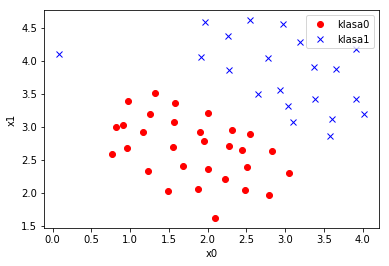

In [50]:
rysujDaneGrup(X, y, marker=('or','xb'), xlabel='x0', ylabel='x1',legend_list=('klasa0','klasa1'))
plt.show()

#### Trenujemy model

In [35]:
model  = svmTrain(X, y, C=1, kernelFunction = 'linearKernel', tol = 1e-3, max_passes = 20,sigma = 10) 

Obliczam macierz jądra
Trenuję ...
6
1
4
5
2
3
3
10
6
7
5
3
0
4
5
2
4
2
3
1
3
3
6
2
4
4
4
5
6
2
0
2
3
1
3
2
1
0
3
1
3
3
2
0
2
2
4
2
0
1
3
1
0
1
3
2
2
1
4
2
0
3
1
0
4
1
1
2
1
0
1
0
0
0
3
1
2
1
0
1
1
4
2
3
0
2
1
2
1
4
3
3
1
2
3
0
1
2
1
3
2
1
0
1
1
1
1
0
1
2
0
2
0
1
2
0
2
3
0
0
2
0
0
1
0
1
1
0
1
2
1
1
0
2
1
3
1
2
0
2
1
1
1
2
0
2
0
1
1
1
0
0
0
1
0
0
1
1
0
1
1
0
1
0
0
3
0
1
0
2
0
3
2
0
1
0
1
0
1
0
1
0
0
0
1
0
0
0
0
2
0
0
1
1
1
0
1
0
1
1
0
1
0
0
0
0
1
0
1
2
0
1
1
3
0
1
1
0
1
1
0
1
0
1
0
0
0
1
0
1
0
1
1
0
1
0
1
1
0
2
2
0
0
1
0
0
2
1
1
1
1
1
1
0
0
2
2
0
2
1
1
0
0
2
0
1
0
2
1
0
1
0
1
1
0
1
1
0
0
0
0
0
0
0
1
0
1
1
0
2
1
0
0
2
0
0
1
0
1
1
0
1
1
0
0
0
0
0
2
2
1
2
1
0
0
1
1
0
1
1
1
0
0
0
2
1
0
0
1
0
1
1
2
0
0
1
0
1
0
1
0
0
0
1
1
1
0
0
0
0
1
2
2
1
0
0
0
3
2
1
2
2
0
2
0
0
2
1
0
0
0
0
1
1
0
0
0
0
3
1
0
1
1
1
1
0
1
1
1
0
1
3
1
1
1
0
0
1
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
1
0
1
0
0
0
2
0
1
0
2
1
1
0
0
2
1
0
0
0
1
1
1
1
0
0
0
0
0
0
1
0
2
1
0
1
0
1
0
1
1
1
2
1
2
0
1
3
0
0
0
1
1
2
0
0
0
0
1
1
0
1
0
0
0
1
2


#### Prezentujemy podział przestrzeni wejść reprezentowany przez model

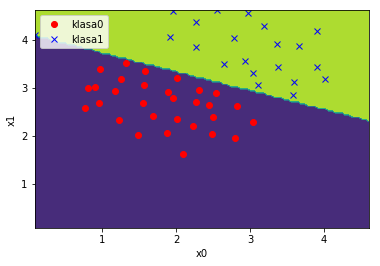

In [36]:
rysujDaneGrup(X, y, marker=('or','xb'), xlabel='x0', ylabel='x1',legend_list=('klasa0','klasa1'))
rysujPodzial(model,X)
plt.show()

#### A jak jest dla innych wartości C?
Jak pamiętamy z wykładu parametr C to współczynnik regularyzacji SVM, który karze za naruszanie marginesów. 
* Proszę wykonać  kod dla C o wartościach {1,2,5,10,20,30,60,120}  i zaobserwować wyniki.

**Wnioski:** Dla zbyt małego C, punkt na który mieliśmy zwrócić uwagę leży na złej półpłaszczyźnie. Od C=30 leży na dobrej - dalsze zwiększanie C nie ma większego sensu bo margines i tak nie będzie istotnie lepszy.
Liczba wektorów wspierających dla tego zestawu danych miała tendencję malejącą ze wzrostem C, ale tylko do pewnego momentu.

## Ćwiczenie 2: jądro Gaussowskie
W  programie proszę zmodyfikować wywołanie <tt>svmTrain</tt>:
*  podmienić funkcję jądra na <tt>'gaussianKernel'</tt>.
* ustawić C = 10
* zmieniać sigma na wartości: {0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8}

Obliczam macierz jądra
Trenuję ...
12
9
2
5
6
4
2
3
4
1
0
3
1
3
0
1
0
1
0
0
1
1
0
2
1
0
0
0
1
1
1
1
1
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  25


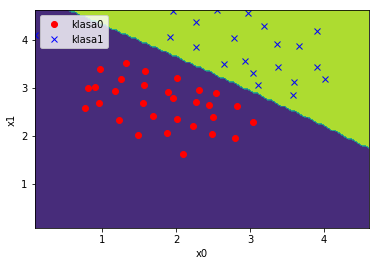

In [51]:
model  = svmTrain(X, y, C = 10, kernelFunction = 'gaussianKernel' , tol = 1e-3, max_passes = 20,sigma = 8) 
rysujDaneGrup(X, y, marker=('or','xb'), xlabel='x0', ylabel='x1',legend_list=('klasa0','klasa1'))
rysujPodzial(model,X)
plt.show()

## Ćwiczenie 3: skomplikowany podział nieliniowy

Przy pomocy kodu z ćwiczenia 2 proszę dobrać parametry C i sigma aby otrzymać sensownie wyglądający podział przestrzeni dla danych zawartych w pliku Dane2.txt.

Obliczam macierz jądra
Trenuję ...
54
72
79
102
104
99
111
96
89
103
75
78
63
64
62
42
61
61
71
53
54
46
49
45
53
39
57
39
51
38
52
42
37
41
42
37
43
34
42
36
39
38
29
35
27
25
41
36
31
26
31
26
21
21
23
22
24
20
26
20
23
20
24
21
26
23
22
24
17
24
20
19
16
24
17
20
13
20
19
22
24
16
31
31
26
26
22
34
25
31
16
27
24
25
19
19
12
19
11
20
18
18
20
19
12
19
16
13
15
13
15
16
14
10
19
15
16
13
23
18
21
12
15
19
22
9
15
10
10
16
14
16
12
9
16
16
13
17
19
16
14
17
15
15
17
15
11
18
9
14
17
7
20
10
7
17
8
16
9
4
7
9
12
5
16
6
12
9
11
13
8
12
9
12
7
8
11
8
10
7
8
14
10
8
9
8
11
11
11
9
9
13
9
12
10
10
6
12
14
7
9
13
13
6
6
9
9
6
9
8
8
10
5
8
7
11
13
14
8
10
7
6
11
9
5
8
2
14
8
11
7
7
6
6
7
9
9
6
9
9
6
7
11
8
8
7
8
8
12
9
4
6
10
6
9
12
11
9
10
10
10
11
6
7
8
6
11
11
6
7
11
7
9
3
7
9
12
6
3
14
7
8
6
12
10
3
4
9
7
7
10
8
4
5
8
9
3
9
5
5
12
9
8
7
7
7
5
7
5
6
6
4
8
3
6
7
4
3
4
9
7
6
6
9
4
6
4
9
3
4
5
8
4
6
7
5
4
3
5
4
6
8
5
7
6
6
5
11
7
8
3
4
2
5
6
5
3
5
8
2
7
6
6
4
1
3
3
5
3
5
8
2
9
7
6
6
7
4
2
12

0
1
0
2
1
4
1
3
0
1
0
0
2
1
3
1
0
1
1
2
2
0
0
1
0
3
3
2
2
0
0
2
1
0
1
0
1
1
2
0
2
1
2
1
0
3
0
0
0
0
2
2
1
3
2
0
1
3
1
1
2
1
0
3
2
1
0
0
0
0
2
2
2
2
1
0
2
1
3
2
2
2
2
1
2
0
3
0
2
1
0
2
1
1
1
2
0
1
1
3
3
3
1
1
1
0
0
0
2
1
1
0
2
0
1
1
2
0
2
1
2
0
2
0
1
2
0
3
2
1
1
1
1
5
2
2
2
2
1
0
1
0
1
3
1
2
1
1
2
4
0
0
1
1
0
2
0
2
2
1
1
2
0
1
5
3
2
2
2
2
0
0
1
1
1
0
1
0
3
2
0
1
3
1
3
0
3
1
0
0
2
0
1
3
1
0
2
0
0
0
0
1
0
1
5
1
1
1
2
2
1
4
2
0
1
0
0
1
3
2
0
1
0
1
2
1
1
1
0
4
4
0
0
3
2
2
1
1
1
3
1
0
0
0
2
0
1
2
1
0
2
1
3
0
1
1
1
1
0
1
0
0
0
0
0
0
0
0
2
1
2
0
1
1
2
0
2
2
1
2
1
0
2
1
0
2
0
1
0
4
1
0
2
2
1
1
0
1
1
3
3
1
0
0
0
1
2
0
1
1
1
1
1
0
1
1
2
3
1
4
0
0
1
0
1
2
0
1
0
1
1
1
3
3
1
1
5
2
3
1
4
1
2
0
0
0
4
0
0
0
1
1
0
3
2
1
0
1
1
4
2
1
2
2
6
0
0
1
0
0
3
3
0
0
0
1
2
2
1
1
0
0
0
1
0
1
1
3
0
2
3
1
1
1
1
1
0
3
3
1
1
3
2
1
2
4
3
0
0
0
1
2
1
1
0
2
2
1
1
1
1
0
1
2
0
2
0
3
1
0
2
1
0
0
0
3
1
1
2
0
1
0
2
3
1
2
2
1
2
1
2
3
2
2
0
2
1
2
1
0
0
2
1
1
0
5
2
1
2
2
1
1
1
1
4
2
0
0
3
1
1
3
0
1
2
0
0
1
0
2
0
3
0
1
2
0
1
0
3
1


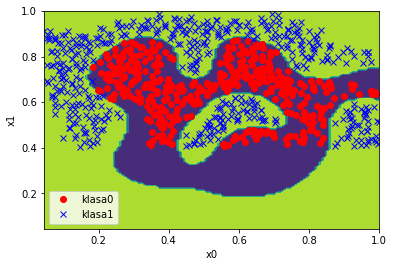

In [54]:
dane = np.loadtxt(folder + 'Dane2.txt') # dane zorganizowane są w trzech kolumnach
N_przyk, N_wej = dane.shape 
X = dane[:,0:2] # pierwsze dwie kolumny to wejście
y = dane[:,2] # trzecia kolumna to etykiety klas

model  = svmTrain(X, y, C = 50, kernelFunction = 'gaussianKernel' , tol = 1e-3, max_passes = 20,sigma = 0.1) 
rysujDaneGrup(X, y, marker=('or','xb'), xlabel='x0', ylabel='x1',legend_list=('klasa0','klasa1'))
rysujPodzial(model,X)
plt.show()




## Ćwiczenie 4: automatyzacja dobierania parametrów C i sigma 

W wielu prawdziwych zastosowaniach chcielibyśmy aby nasz wybór parametrów był optymalny a jednocześnie możliwie  obiektywny. 

Powszechnie stosowaną metodą jest przeszukanie przestrzeni parametrów (C,sigma). Generuje się siatkę wartości (C,sigma) i dla każdego punktu siatki:

* estymuje się model
* ocenia się jakość generalizacji 

Do oceny jakości w każdym punkcie siatki można zastosować albo  zbiór monitorujący albo metody typu leave-one-out.

**Uwaga**: podział przestrzeni często wykonuje się w skali logarytmicznej.

Ćwiczenie wykonamy dla zbioru uczącego z pliku dane3.txt.

* wczytywanie danych

In [56]:
dane = np.loadtxt(folder + 'Dane3.txt') # dane zorganizowane są w trzech kolumnach
N_przyk, N_wej = dane.shape 
X = dane[:,0:2] # pierwsze dwie kolumny to wejście
y = dane[:,2] # trzecia kolumna to etykiety klas

Musimy ten zbiór podzielić na dane do trenowania i dane do testowania np. w proporcji 3:1, Można to zrobić tak:

* Rozdzielamy dane na grupy:

In [57]:
grupa0, = np.where(y==-1)
grupa1, = np.where(y==1)

* mieszamy kolejność indexów w każdej grupie

In [58]:
np.random.shuffle(grupa0)
np.random.shuffle(grupa1)

* kopiujemy dane do zbioru uczącego (pierwsze 75% grupy0 i grupy1)

In [59]:
Xu = X[np.concatenate((grupa0[0: int(0.75*len(grupa0))],grupa1[0:int(0.75*len(grupa0))]))]
yu = y[np.concatenate((grupa0[0: int(0.75*len(grupa0))],grupa1[0:int(0.75*len(grupa0))]))]

* kopiujemy dane do zbioru testowego (końcowe 25% grupy0 i grupy1)

In [60]:
Xt = X[np.concatenate((grupa0[int(0.75*len(grupa0)):], grupa1[int(0.75*len(grupa0)):]))]
yt = y[np.concatenate((grupa0[int(0.75*len(grupa0)):], grupa1[int(0.75*len(grupa0)):]))]

* narysujmy te dane

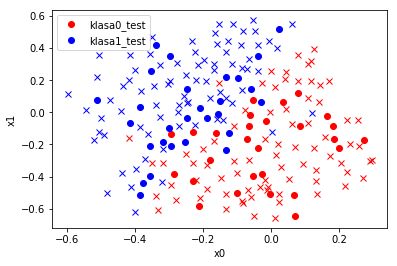

In [61]:
rysujDaneGrup(Xu, yu, marker=('xr','xb'), xlabel='x0', ylabel='x1',legend_list=('klasa0','klasa1'))
rysujDaneGrup(Xt, yt, marker=('or','ob'), xlabel='x0', ylabel='x1',legend_list=('klasa0_test','klasa1_test'))
plt.show()

Mając taki podział danych możemy dopasować model SVM do części uczącej:

Obliczam macierz jądra
Trenuję ...
6
6
5
10
16
14
11
13
10
13
18
11
10
15
8
13
7
11
8
5
10
11
7
8
6
6
3
4
5
4
9
5
5
3
4
3
4
5
4
5
4
2
2
2
3
4
3
1
0
2
2
0
3
2
2
2
1
1
2
0
0
0
2
2
3
2
0
0
1
1
1
0
0
2
1
2
0
2
1
3
1
1
2
0
2
1
1
1
0
0
0
1
1
2
1
0
0
1
0
0
0
1
3
0
1
3
1
1
2
3
1
0
1
0
0
0
1
2
0
0
1
0
1
1
0
1
0
0
1
2
1
0
0
1
1
0
0
1
1
1
0
0
0
0
0
0
0
0
2
0
0
0
0
0
1
0
0
1
1
0
0
0
2
0
0
0
1
1
0
1
1
1
1
1
2
0
0
1
1
1
0
1
0
0
0
0
0
1
2
1
0
0
0
0
0
0
1
0
2
0
0
1
0
2
3
2
1
1
0
0
0
0
0
1
0
1
2
0
1
1
0
0
0
1
0
0
0
1
0
1
0
0
0
0
0
1
0
1
1
0
0
1
1
0
0
0
0
0
0
1
1
0
1
1
0
0
0
0
2
0
0
0
0
0
1
0
1
0
0
3
1
1
1
0
1
0
1
1
1
0
0
1
1
0
0
0
0
0
0
2
0
0
0
1
0
1
0
1
0
0
1
2
0
2
0
0
0
0
1
1
2
0
3
0
3
0
0
0
0
1
0
0
1
0
0
0
1
1
2
0
0
1
0
0
0
1
0
1
1
0
1
1
0
0
0
1
0
2
1
0
0
0
0
0
0
0
2
0
0
1
1
0
0
0
0
2
0
1
1
0
0
1
1
1
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
0
0
1
1
0
1
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
2
0
0
0
0
1
0
0
0
0
1
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
1
1
0
0
1
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0


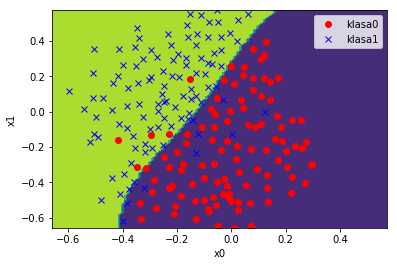

In [77]:
model  = svmTrain(Xu, yu, C=10, kernelFunction = 'gaussianKernel', tol = 1e-3, max_passes = 20,sigma = 0.5) 
rysujDaneGrup(X, y, marker=('or','xb'), xlabel='x0', ylabel='x1',legend_list=('klasa0','klasa1'))
rysujPodzial(model,X)
plt.show()

A następnie ocenić jego jakość na części testowej (funkcja <tt>svmPredict</tt> dostarczana jest przez moduł svm_modul.py):

In [78]:
TPR = np.sum(yt == svmPredict(model,Xt))/float(len(yt))
print(TPR)

0.8545454545454545


#### Proszę napisać kod, który
* skanuje przestrzeń (C,sigma): C w zakresie od 0.1 do 100, sigma w zakresie od 0.1 do 10. Do wygenerowania zakresu ze skalą logarytmiczną można wykorzystać np. takie polecenie: <tt>zakresC = np.logspace(np.log2(0.1),np.log2(100),8, base=2)</tt>
* znajduje najlepsze parametry
* rysuje podział przestrzeni dla najlepszych parametrów.

Obliczam macierz jądra
Trenuję ...
42
27
34
23
24
12
17
12
12
11
10
6
4
6
4
4
6
5
6
5
2
2
3
4
1
4
4
2
0
6
4
3
3
2
2
0
3
4
2
0
2
1
4
1
3
2
3
2
1
1
1
1
1
4
2
0
1
2
0
0
1
3
3
0
1
4
2
0
1
0
0
1
3
0
0
0
0
1
1
1
0
1
0
0
1
2
0
0
1
0
2
1
1
0
1
2
1
2
1
1
0
1
2
1
0
0
1
0
0
0
0
0
0
0
2
2
0
0
1
1
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
1
1
0
0
0
0
0
2
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
2
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  152
TPR =  0.8181818181818182
C =  0.1 , sigma =  0.1
Obliczam macierz jądra
Trenuję ...
43
27
18
16
11
23
13
13
11
2
9
5
5
5
6
5
3
5
2
3
4
5
3
3
4
4
4
0
3
3
1
1
4
1
2
1
3
0
1
0
3
1
0
2
0
3
0
1
0
0
0
0
0
0
0
1
0
0
1
0
1
1
1
0
2
0
1
0
1
0
2
2
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
1
0
1
0
0
0
1
0
0
0
0
1
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
1
0
0
0
1
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
0
0
1
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  93
TPR =  0.8727272727272727
C =  0.719685673001152 , sigma =  0.1
Obliczam macierz jądra
Trenuję ...
27
18
25
27
24
22
16
18
14
16
21
9
8
12
4
6
8
11
8
6
8
8
6
7
7
3
3
6
9
3
1
5
1
2
3
5
0
5
4
4
4
2
1
2
0
3
2
2
2
3
2
3
4
1
2
2
3
1
1
1
5
3
2
3
3
2
5
1
2
3
2
0
2
3
1
2
3
4
0
1
2
4
1
2
0
0
2
0
1
3
1
2
1
2
1
1
0
1
2
1
1
0
0
3
0
2
2
1
5
1
2
1
2
2
3
1
0
0
2
2
2
1
1
3
1
2
1
0
1
1
1
0
1
0
0
1
0
2
0
1
2
0
1
0
0
1
1
0
1
0
0
1
0
1
2
0
0
0
1
0
0
0
0
0
0
0
1
3
0
1
0
0
0
1
0
0
1
0
2
1
0
0
0
0
0
0
0
0
2
1
0
1
0
0
1
0
2
1
1
0
1
1
0
3
1
0
1
0
0
0
0
1
0
0
0
0
0
1
1
0
0
1
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba 

13
17
12
5
8
2
2
5
2
3
2
2
3
0
0
1
1
1
1
1
1
2
0
0
0
2
1
0
1
1
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
1
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  154
TPR =  0.4909090909090909
C =  1.9306977288832508 , sigma =  9.999999999999998
Obliczam macierz jądra
Trenuję ...
18
51
56
64
75
83
69
57
54
54
57
44
45
46
41
32
41
27
31
36
32
38
36
32
29
31
28
31
34
21
24
23
23
21
21
21
30
24
27
21
14
17
16
18
18
18
22
23
16
17
14
19
12
19
17
18
18
13
12
17
15
15
15
18
12
10
15
11
15
9
13
12
12
7
9
13
12
20
10
9
9
14
8
13
11
13
12
10
14
15
15
6
13
9
8
16
12
9
10
13
11
9
11
12
12
10
4
9
10
4
7
13
10
3
6
8
2
6
6
8
5
9
6
5
12
9
7
9
6
9
12
10
4
8
12
8
11
3
5
4
9
5
8
10
11
8
10
4
8
4
8
9
6
6
7
4
3
8
3
5
6
3
5
4
5
9
8
8
6
8
6
4
3
5
3
2
6
5
3
5
3
5
5
6
2
9
9
5
4
4
8
12
6
14
6
5
8
4
6
7
8
6
9
8
5
4
5
3
5
6
4
8
7
5
6
3
6
5
2
4
3
3
2
7
5
2
3
6
8
4
5
2
5
2
8
6
5
2
5
3
2
4
3
5
3
5
7
3
2
4
3
6
2
6
8
3
6
2
5
4
8
6
6
5
3
2
7
4
2
3
8
8
5
8
7

57
58
58
47
45
47
39
47
47
46
38
43
46
46
42
42
48
34
38
40
35
37
36
46
38
30
32
32
34
31
38
25
35
18
35
23
27
22
23
22
22
18
23
21
26
23
26
25
25
25
24
21
16
17
24
17
21
24
21
25
25
18
19
25
20
19
28
15
26
16
8
17
15
11
19
18
14
14
15
16
19
16
16
18
13
14
15
14
18
14
16
16
14
17
15
16
9
16
19
13
17
9
18
14
15
8
12
16
14
15
10
12
20
14
14
19
14
18
15
11
9
11
12
13
10
13
13
10
15
8
10
16
16
15
13
14
16
16
9
14
17
10
8
15
17
14
9
12
13
12
5
9
12
17
12
7
9
11
9
11
9
11
7
6
7
8
10
11
15
13
10
7
5
8
11
2
14
12
9
7
5
12
6
11
7
7
11
10
4
10
4
10
4
13
12
10
8
7
7
4
4
8
11
11
14
5
10
5
10
4
6
7
7
9
6
4
9
5
3
7
4
6
7
5
7
1
3
2
5
7
4
3
7
2
3
9
7
6
4
5
3
7
4
0
3
2
3
3
3
1
5
2
1
1
7
4
4
3
2
5
5
5
1
4
3
5
4
4
1
4
1
3
2
3
1
2
2
1
3
1
3
0
2
1
1
1
3
1
1
1
2
2
1
1
5
1
1
3
0
1
3
0
1
1
1
1
1
1
1
3
2
4
0
0
1
1
1
2
2
0
0
1
1
0
0
0
0
2
1
0
1
0
0
0
1
0
1
0
0
2
1
2
1
0
0
2
1
2
0
1
1
2
1
2
1
1
0
1
3
1
0
1
0
0
2
1
4
2
0
0
0
0
1
0
0
1
0
1
0
0
1
1
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Go

0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  88
TPR =  0.8363636363636363
C =  13.89495494373137 , sigma =  5.179474679231211
Obliczam macierz jądra
Trenuję ...
48
17
16
12
11
9
7
3
3
4
6
2
3
4
1
2
3
1
1
1
3
1
0
1
1
1
1
2
4
0
0
2
0
0
0
1
0
1
2
1
1
0
1
2
0
1
0
1
0
0
1
0
1
1
1
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  125
TPR =  0.8363636363636363
C =  13.89495494373137 , sigma =  9.999999999999998
Obliczam macierz jądra
Trenuję ...
23
42
66
64
72
65
65
59
58
52
42
44
50
41
48
34
43
50
41
46
37
27
38
47
44
39
29
26
36
29
37
34
36
44
32
28
27
37
28
25
26
37
28
22
26
26
27
32
34
24
31
28
24
28
21
22
26
21
20
23
15
27
18
18
12
19
20
21
20
20
18
18
18
19
16
13
19
13
11
16
15
19
14
13
19
19
13
16
11
18
19
11
15
19
17
15
14
1

0
0
0
0
0
0
0
0
1
0
0
0
0
2
1
0
0
1
0
3
0
1
2
1
0
0
0
0
2
0
0
2
1
1
0
0
1
1
1
0
1
2
0
0
0
2
0
0
1
0
0
1
2
0
0
0
0
1
1
1
0
3
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
0
2
1
1
0
0
0
0
0
0
1
0
0
0
0
0
2
0
0
1
0
1
0
1
0
0
0
0
0
1
0
0
0
0
1
1
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
0
0
1
2
0
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
1
0
0
1
0
0
0
1
0
0
0
2
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
1
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  45
TPR =  0.8727272727272727
C =  37.27593720314943 , sigma =  0.372759372031494
Obliczam macierz jądra
Trenuję ...
13
17
19
22
17
23
15
12
9
16
22
13
12
17
17
13
8
14
13
8
9
8
9
8
8
14
10
9
6
4
5
6
2
5
5
6
5
6
4
4
3
1

3
3
4
5
1
5
3
4
2
2
0
2
2
4
5
3
5
5
4
6
4
2
1
0
5
8
3
4
3
3
4
4
1
4
2
3
2
2
3
5
3
7
2
2
5
5
3
2
5
4
2
2
6
6
2
1
1
4
3
5
4
1
2
1
1
3
2
3
2
3
3
2
6
2
2
3
5
1
1
2
3
5
1
7
1
2
1
3
1
1
3
2
2
4
5
4
4
4
2
2
4
4
4
3
3
4
3
6
4
3
3
3
2
1
1
1
2
4
2
0
2
3
2
2
3
2
1
1
2
1
2
4
0
2
2
3
0
0
3
0
0
0
1
3
1
2
2
1
0
0
2
0
0
1
0
0
1
3
0
2
2
1
2
2
1
1
2
0
1
1
0
2
2
0
0
0
0
2
0
4
4
0
3
2
0
2
3
0
1
3
0
0
2
2
2
2
1
1
2
1
1
3
0
1
0
3
3
0
2
1
0
1
0
0
1
0
0
0
1
0
1
1
2
2
2
0
0
0
2
2
0
1
1
1
0
0
1
2
1
0
1
2
1
1
0
1
0
0
0
1
0
0
1
0
0
1
2
2
1
0
0
1
1
1
2
0
2
2
0
2
0
0
0
0
0
1
1
3
3
1
0
2
1
1
1
0
0
0
0
1
1
1
1
0
0
1
0
3
2
1
1
0
0
0
4
1
0
0
0
0
0
1
1
1
1
1
0
1
1
4
3
1
0
2
1
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
0
1
1
1
0
2
2
0
0
0
1
0
0
1
1
1
0
0
0
0
0
1
0
1
0
3
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  62
TPR =  0.8363636363636363
C =  99.99999999999997 , sigma =  0.1
Obliczam macierz jądra
Trenuję ...
12
20
29
33
37
41
50
46
45
36
40
44


7
7
3
4
4
4
9
10
3
6
6
6
3
9
6
5
3
6
4
3
5
2
5
4
5
1
3
5
2
3
6
2
2
0
0
2
3
0
1
5
2
2
2
3
2
7
6
2
2
1
6
1
5
4
8
1
3
3
4
1
0
7
4
8
2
0
1
5
5
4
4
3
1
1
4
6
5
2
2
9
0
4
5
7
6
3
4
4
4
5
2
8
6
3
4
2
3
7
6
5
9
6
4
3
2
5
5
4
8
4
4
7
3
4
6
6
4
5
6
5
6
5
4
5
2
5
4
4
3
1
7
3
4
5
3
3
2
3
5
4
1
4
3
5
1
3
4
1
3
1
3
2
2
4
3
3
3
4
5
1
1
2
2
2
1
2
1
0
3
1
1
3
0
1
2
2
3
2
3
0
0
3
4
2
0
2
2
3
2
0
2
0
1
5
2
1
2
1
1
3
1
1
3
2
1
1
3
4
2
2
2
1
1
2
0
0
2
2
1
3
0
1
2
2
4
0
2
2
0
4
1
0
1
1
1
2
2
0
0
1
1
1
5
3
3
1
2
0
1
0
2
2
1
2
1
2
5
1
1
0
3
1
1
5
3
3
3
3
1
1
0
1
1
1
2
1
0
1
1
1
1
1
0
1
2
0
1
1
1
0
3
1
1
4
2
1
1
0
3
1
5
0
2
2
3
0
4
0
1
1
0
2
2
1
2
0
0
1
3
1
1
0
0
1
0
1
0
1
0
3
0
0
0
3
1
1
0
3
0
1
1
0
3
2
1
1
2
2
0
1
0
1
1
2
1
1
1
1
1
1
1
0
3
0
2
0
1
3
1
1
2
0
1
0
0
2
3
0
2
1
0
0
1
1
0
2
2
1
2
0
1
1
0
1
1
1
0
3
0
3
3
0
2
1
0
2
1
1
0
0
0
0
0
1
1
1
1
1
0
2
2
3
2
1
2
3
1
0
1
1
0
2
0
0
3
2
1
0
0
1
1
0
3
1
1
1
3
0
2
2
1
1
1
0
2
3
3
1
0
0
0
1
0
2
1
1
1
1
0
4
0
1
0
1
0
1
0
0
1
1
0
2
1
2
2
0
2
1
3
3
2
0
1
3
0
1
1
0
2
1

1
0
2
0
0
0
1
0
0
1
1
1
0
1
1
1
1
2
2
2
0
0
1
1
1
0
2
0
1
0
0
0
0
0
2
0
0
1
0
0
0
1
2
0
2
1
1
0
1
2
1
1
0
0
0
0
1
2
0
2
0
3
1
0
0
1
0
0
0
0
0
1
1
0
2
0
0
0
0
1
0
1
0
0
0
1
0
0
1
0
0
0
0
1
2
1
1
1
0
2
0
2
5
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
2
0
0
0
2
0
1
0
0
1
0
2
0
2
1
0
0
0
1
2
1
0
1
0
1
1
0
2
2
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
2
1
0
1
0
0
3
2
1
1
1
2
0
1
1
0
0
0
1
2
1
1
0
2
0
0
0
1
0
0
0
0
0
2
1
1
0
1
0
0
1
1
0
0
1
2
0
1
1
1
1
0
1
0
0
1
0
2
2
1
2
2
0
0
0
3
0
0
0
1
0
1
1
0
0
1
0
0
0
0
0
1
1
0
1
2
0
2
0
0
0
1
1
0
1
0
0
0
1
0
1
2
2
0
1
0
1
3
0
1
0
1
1
0
1
0
2
0
0
1
2
1
0
0
1
2
0
0
1
0
0
1
1
1
1
0
2
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
2
1
1
1
0
1
1
0
1
0
0
3
0
1
1
2
1
0
0
1
1
1
0
2
0
0
0
0
0
0
0
0
1
1
0
0
2
1
1
1
0
2
0
1
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
2
1
1
1
1
1
2
0
1
1
1
1
0
0
0
4
2
2
1
0
0
0
0
0
1
2
2
0
2
0
0
0
0
0
1
1
1
0
0
1
0
0
1
1
1
1
0
1
1
0
0
0
0
0
0
0
1
0
1
0
1
0
1
0
0
0
1
0
2
0
0
1
0
1
0
0
0
0
0
0
2
2
1
1
0
1
1
1
0
1
2
2
0
1
1
0
0
1
0
0
1
0
0
0
0
0
1
1
0
0
0
0
2
2
3
0
1
0
0
0
0
0
0
1


0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  50
TPR =  0.8727272727272727
C =  99.99999999999997 , sigma =  1.3894954943731377
Obliczam macierz jądra
Trenuję ...
7
19
17
16
18
19
12
17
11
8
6
9
6
5
3
4
4
4
7
6
5
8
8
4
4
2
2
2
3
2
2
2
3
3
3
4
3
2
3
2
3
2
2
2
1
3
1
3
1
0
1
0
0
1
0
2
2
3
1
1
1
5
4
0
1
2
2
1
2
1
0
1
1
1
0
1
0
1
0
0
0
0
2
0
2
0
0
3
0
1
0
0
2
2
0
0
1
0
0
0
1
0
0
1
0
0
1
2
2
0
0
1
0
0
0
0
1
2
1
1
0
1
2
1
0
0
2
0
1
0
1
1
1
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
1
1
1
2
1
0
0
0
0
0
1
0
0
1
3
0
1
1
0
0
1
0
2
0
2
0
0
0
0
0
0
0
0
0
3
0
0
0
0
1
1
1
0
0
1
0
0
1
1
0
0
0
0
1
0
2
0
0
0
0
1
1
1
0
0
1
0
0
0
0
0
2
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
0
2
0
1
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
2
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Gotowe! 


liczba wektorów wspierających:  53
TPR =  0.8727272727272727
C =  99.99999999999997 , sigma =  2.6826957952797255
Obliczam macier

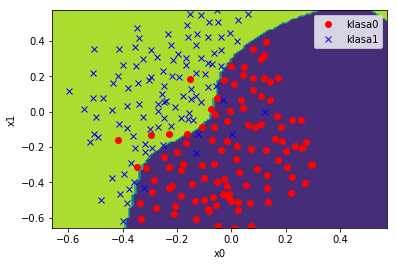

In [74]:
Cmin=0.1
Cmax=100
smin=0.1
smax=10

zakresC = np.logspace(np.log2(Cmin),np.log2(Cmax),8, base=2)
zakress = np.logspace(np.log2(smin),np.log2(smax),8, base=2)

TPRmax=0
modelBest=None
Cbest=0
sbest=0

for Cval in zakresC:
    for sval in zakress:
        
        model  = svmTrain(Xu, yu, C=Cval, kernelFunction = 'gaussianKernel', tol = 1e-3, max_passes = 20,sigma = sval)
        TPR = np.sum(yt == svmPredict(model,Xt))/float(len(yt))
        print('TPR = ',TPR)
        print('C = ',Cval,', sigma = ',sval)
        print('========================================')
        
        if TPR > TPRmax:
            TPRmax=TPR
            Cbest=Cval
            sbest=sval
            modelBest=model

print('TPRmax = ',TPRmax)
print('Cbest = ',Cbest,', sigmabest = ',sbest)
rysujDaneGrup(X, y, marker=('or','xb'), xlabel='x0', ylabel='x1',legend_list=('klasa0','klasa1'))
rysujPodzial(modelBest,X)
plt.show()
            

        

##Jak zastosować SVM do problemu wieloklasowego? Podejścia są dwa:##

**1. one-versus-one ('ovo')**

tworzonych jest N_klas * (N_klas -1)/2 klasyfikatorów i każdy trenowany jest dla rozróżniania innej pary klas. Każdy z klasyfikatorów "głosuje" za jedną z dwóch klas. Wygrywa klasa, która uzyska najwięcej głosów.

**2. one-versus-rest**

tworzonych jest N_klas klasyfikatorów, każdy trenowany jest do rozróżniania danej klasy od wszystkich pozostałych. Wygrywa ten, który daje najwyższy poziom ufności co do swojej decyzji.

## Dodatkowe źródła dla zainteresowanych: ##
* [Excerpt from the Python Data Science Handbook by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

* [Dyskusja na Stackoverflow](https://stackoverflow.com/questions/9480605/what-is-the-relation-between-the-number-of-support-vectors-and-training-data-and)

* [Tutorial Microsoftu](https://www.microsoft.com/en-us/research/publication/a-tutorial-on-support-vector-machines-for-pattern-recognition/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F67119%2Fsvmtutorial.pdf)




